<h1 style="text-align: center;"> Predicting Water Potability: </h1>
<h2 style="text-align: center;"> A Look into Missing Data Replacement </h2>
<h3 style="text-align: center;"> Eric O'Leary</h3>

Within machine learning and data science, a common issue is missing data. When we work with real-life datasets, not every example has a value for each feature. There are a number of ways of dealing with this depending on the type of data, and we'll compare a few of those methods for numerical data.

Before we get into the machine learning, let's understand a bit more about our dataset. We have nine features, which are: pH, hardness, solids, chloramines, sulfate, conductivity, organic carbon, trihalomethanes, and turbidity.

Note that ideal ranges for these features have been taken mostly on acceptability ratings of taste, odor, and appearance, but in reality, consideration must also be paid to the effect of the water in plumbing, efficacy of treatment methods, and other factors.

pH: A score of how active hydrogen ions are in the solution, which measures acidity. A lower pH indicates higher concentration and higher acidity whereas a high pH indicates a basic solution. This is a scale from 0 to 14, with 7 being neutral at 77 degrees Farenheit. Ideally, water should have a pH of 6.5 to 8.5.

Hardness: A score of dissolved calcium and magnesium, with high hardness being high concetration of those minerals. There is no health-based recommendation for hardness. Generally, <500mg/L is tolerated.

Solids: Total dissolved solids, or TDS, is a score of concetration of all minerals, salts, metals, and more in the water. Generally, <600mg/L is desired, but <1000mg/L is still considered safe.

Chloramines: A score of chlorine and chloramines, the primary disinfectants in public water systems. Chloramines are found when ammonia and chlorine are combined in water treatment. The acceptable range changes for monochloramines, dichloramines, and trichloramines, but the sum of them should not exceed 2mg/L.

Sulfate: A score of sulfate concentration, which is found throughout minerals, living beings, and chemical industry use. Less than 250mg/L has no taste effect, but this changes based on the cation sulfate is paired with.

Conductivity: A score of the electrical conductivity of water. Pure water is an insulator, but high concentrations of ions, generally from dissolved solids, increases electrical conductivity. There is no major guideline for safety, but for reference, distilled water has <3$\mu$S/cm and freshwater is 150-500$\mu$S/cm.

Organic Carbon: Total organic carbon, or TOC, is a score of decaying organic matter, which indicates bacteria and particles of animals and plants. This is not directly regulated.

Trihalomethanes: A score of concentration of trihalomethanes, which are formed when chlorine interacts with organic matter in the water. It depends on the exact trihalomethane, but the highest acceptable concetration of all of them is .3mg/L.

Turbidity: A score of the quantity of solid matter, measured by the water's light emitting properties. Above 4NTU, the naked eye can see the particles in the water, and .2NTU is expected for large suppliers after disinfection.

All of these statistics are taken from the World Health Organization's Guidelines for Drinking-Water Quality, available at https://www.who.int/publications/i/item/9789241549950.

As we'll quickly see, the dataset we use, found at https://www.kaggle.com/datasets/adityakadiwal/water-potability, is very unrealistic, as many potable examples are far beyond these guidelines.

<h2> Machine Learning Preliminaries </h2>

First, we import a few packages that will help us later on. Pandas helps us cleanly manipulate our data, sklearn contains all of our machine learning tools, and the rest perform backround operations or a single function.

In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from matplotlib import pyplot as plt
import graphviz

To start, we import our csv file into a dataframe, and then display it.

In [2]:
df = pd.read_csv('water_potability.csv')
display(df)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


Just looking at the data, we see a few things of note. Firstly, this is a binary classification problem with nine features. The values of each feature vary wildly, such as pH which is zero to fourteen, and solids which has values in the tens of thousands. And, there are quite a few missing values, represented as NaN. We'll need to handle these before we start applying our algorithms.

In [3]:
print("With NaN:", df.shape[0], "; Without NaN:", df.dropna().shape[0])

With NaN: 3276 ; Without NaN: 2011


In fact, almost a third of our examples have a missing value. So, we probably don't want to just remove all of those rows.

<h2> Replacing the Values </h2>

We'll look at four different methods to replace that missing data.

Firstly, we just replace all missing values with zero. This is the lazy approach, and is likely to cause issues with standardization. For example, in the solids column, a values of zero will decrease the mean and increase the standard deviation massively.

Secondly, we'll replace all missing values with the mean of that column. This will cause the smallest amount of deviation from the original dataset, and is commonly the recommendation.

Thirdly, we'll replace missing values with the mean of the column after grouping by classification. This is likely to reinforce existing trends in the data, which will be fine for our existing data, but may struggle if we increase the size of our dataset.

Finally, we'll just remove all examples with a missing value. This decreases our number of examples, which will make the algorithm faster to train but less likely to generalize.

As mentioned, there are many methods to replace missing data, and this is not novel research. For example, https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00516-9 is a very in-depth look at a number of methods, whereas https://medium.com/geekculture/how-to-deal-with-missing-values-in-machine-learning-98e47f025b9c and https://vitalflux.com/pandas-impute-missing-values-mean-median-mode/ provide a more basic explanation.

In [4]:
# Pandas throws a warning for our standardize function, but it works
pd.options.mode.chained_assignment = None

# Function to standardize all columns except the last,
# since that's potability, which we want unchanged
def standardize(df):
    for col in df.columns[:-1]:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

# Replace nan with zero
dfzero = df.copy()
dfzero = dfzero.fillna(0)
dfzero = standardize(dfzero)

# Replace nan with column average
# Note: Since we standardize anyways, we can just replace 
# with 0 after standardization, as we make the mean zero
dfavg = df.copy()
dfavg = standardize(dfavg)
dfavg = dfavg.fillna(0)

# Replace nan with column average, grouped by class
dfgroupavg = df.copy()
varlst = df.columns.drop('Potability')
for col in varlst:
    dfgroupavg[col] = dfgroupavg[col].fillna(dfgroupavg.groupby('Potability')[col].transform('mean'))
dfgroupavg = standardize(dfgroupavg)

# Drop all nan values
dfnone = df.dropna()
dfnone = standardize(dfnone)

Next, we split our dataset into train and test sets and organize them into a structure to loop over.

In [5]:
Xzero,Xtezero,Yzero,Ytezero = train_test_split(dfzero.iloc[:,:-1].to_numpy(), 
                                               dfzero['Potability'].to_numpy(), test_size=.2, random_state=1)
Xavg,Xteavg,Yavg,Yteavg = train_test_split(dfavg.iloc[:,:-1].to_numpy(), 
                                           dfavg['Potability'].to_numpy(), test_size=.2, random_state=1)
Xgravg,Xtegravg,Ygravg,Ytegravg = train_test_split(dfgroupavg.iloc[:,:-1].to_numpy(), 
                                                   dfgroupavg['Potability'].to_numpy(), test_size=.2, random_state=1)
Xnone,Xtenone,Ynone,Ytenone = train_test_split(dfnone.iloc[:,:-1].to_numpy(), 
                                               dfnone['Potability'].to_numpy(), test_size=.2, random_state=1)

# All of our learning models use 
# X = (samples, features)
# Y = (features,)
# which sklearn's train_test_split provides

# Then, we create 4-tuples of datasets
zero = (Xzero, Yzero, Xtezero, Ytezero)
avg = (Xavg, Yavg, Xteavg, Yteavg)
gravg = (Xgravg, Ygravg, Xtegravg, Ytegravg)
none = (Xnone, Ynone, Xtenone, Ytenone)
# And organize into a dataset
datasets = {'Zero':zero, 'Avg':avg, 'Gravg':gravg, 'None':none}

<h2> Training the Models </h2>

We will use two different machine learning algorithms to make predictions on our dataset. 

First, we use a neural network. This is a complex system of nodes which each split their input in half after applying some weights, which allows us to represent difficult, non-linear functions. For a more accurate and in-depth explanation, see https://www.ibm.com/topics/neural-networks or https://www.techtarget.com/searchenterpriseai/definition/neural-network.

Then, we use a decision tree. This is a tree of nodes which split the data by one feature until the leaf layer, where data is classified based on node (explain better). For our numerical data, the algorithm also looks at each possible value to split each feature, and selects the feature and split value with the best score. For a more in-depth explanation, see https://www.ibm.com/topics/decision-trees or https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052.

For our neural network, we want to first select good hyperparameters. Because of the massive number of combinations of hyperparameters, rather than an automated method such as grid search, I chose to manually fiddle with the model until I got a good result. What I ended up with was a model with two hidden layers of size 24 using ADAM optimization. As for max iterations, preliminary results showed neural networks to have poor generalization for this dataset. This occurred when max iterations were 1000, at which point no ConvergenceWarnings were thrown, indicating all networks had trained to convergence. So, I tested to see whether the neural networks were overfitting by comparing accuracies for all datasets as max iterations increase, and to see if early stopping would help.

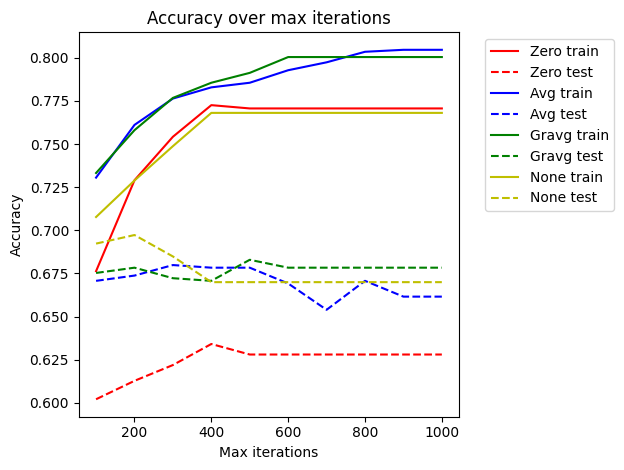

In [6]:
# Since we're intentionally training dozens of networks before convergence,
# we ignore a warning that would otherwise pop up to prevent clutter
simplefilter("ignore", category=ConvergenceWarning)

colors = ['r', 'b', 'g', 'y']

for i, key in enumerate(datasets):
    trainacc = []
    testacc = []
    X,Y,Xte,Yte = datasets[key]
    for it in [100,200,300,400,500,600,700,800,900,1000]:
        clf = MLPClassifier(solver='adam', alpha=1e-4,
                   hidden_layer_sizes=(24,24), random_state=1,
                   max_iter=it)
        clf.fit(X,Y)
        trainacc += [clf.score(X,Y)]
        testacc += [clf.score(Xte,Yte)]
    plt.plot(range(100,1100,100), trainacc, colors[i], label=key+' train')
    plt.plot(range(100,1100,100), testacc, colors[i]+'--', label=key+' test')

plt.title("Accuracy over max iterations")
plt.xlabel("Max iterations")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

The graph confirms that these networks should have converged by 1000 iterations, but it also shows that most of the networks are close enough at 800 iterations, which not only saves time, but improves the accuracy of Average. So, we can use 800 iterations going forward for convergence.

If we look at overfitting, however, we see noticeable performance drops in all networks' test accuracy starting around 400 iterations while training accuracy is either stabilized or increasing. For best performance and generalization, we'd want to pick on a case-by-case basis the exact iterations to maximize test accuracy for each network. However, for our purposes, we only want a network that performs well enough in many different cases. For this purpose, we use max iterations of 500, which maximizes test accuracy across all cases.

Now that we know our hyperparameters for our network, we can apply it to all of our datasets and get results.

In [7]:
clf = MLPClassifier(solver='adam', alpha=1e-4,
                   hidden_layer_sizes=(24,24), random_state=1,
                   max_iter=500)

nntrain, nntest = [], []
for key in datasets:
    X,Y,Xte,Yte = datasets[key]
    clf.fit(X,Y)
    nntrain += [clf.score(X,Y)]
    nntest += [clf.score(Xte,Yte)]
    print(key, ": Training accuracy:", clf.score(X,Y), "Testing accuracy:", clf.score(Xte,Yte))

Zero : Training accuracy: 0.7706106870229008 Testing accuracy: 0.6280487804878049
Avg : Training accuracy: 0.7854961832061069 Testing accuracy: 0.6783536585365854
Gravg : Training accuracy: 0.7912213740458015 Testing accuracy: 0.6829268292682927
None : Training accuracy: 0.7680348258706468 Testing accuracy: 0.6699751861042184


Next, we test hyperparameters for our decision tree. Luckily, there's only one hyperparameter that we really want to tune, and that's depth. So, we train a decision tree for depths 0 to 30 and see where we get the best test accuracy. 

There is an interesting thing to note here: there is a lot of possible fluctuation for both the neural network and the decision tree depending on random factors, but it's much more noticeable for the decision tree. Specifically, we set random_state to 1 in both train_test_split and when initializing our decision tree. The point of random_state is to provide a seed for the random number generation. Selecting a specific random_state makes our algorithm deterministic, allowing for more exact reproduction. There may be random states for both that maximize performance, but we choose 1 for simplicity. 

Even without fixing random_state for both the split and the classifier, around depth 6 gives the best results.

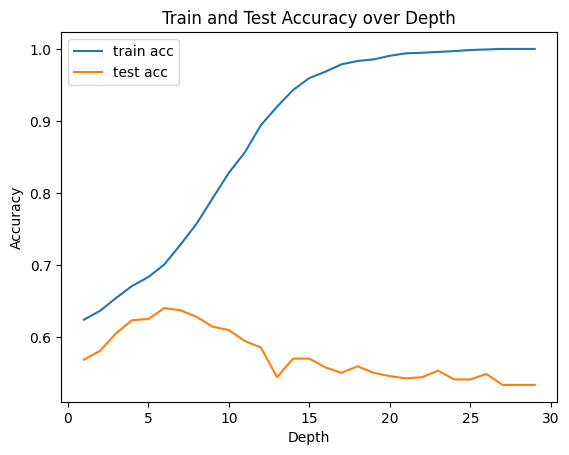

In [8]:
trainacc, testacc = [], []
for depth in range(1,30):
    clf = tree.DecisionTreeClassifier(max_depth=depth, random_state=1)
    clf.fit(Xzero,Yzero)
    trainacc += [clf.score(Xzero,Yzero)]
    testacc += [clf.score(Xtezero,Ytezero)]

plt.plot(range(1,30), trainacc, label='train acc')
plt.plot(range(1,30), testacc, label='test acc')
plt.title('Train and Test Accuracy over Depth')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

Now, we use our selected hyperparameter and loop over our datasets.

In [9]:
clf = tree.DecisionTreeClassifier(max_depth=6)

dttrain, dttest = [], []
for key in datasets:
    X,Y,Xte,Yte = datasets[key]
    clf.fit(X,Y)   
    dttrain += [clf.score(X,Y)]
    dttest += [clf.score(Xte,Yte)]
    print(key, ": Training accuracy:", clf.score(X,Y), "Testing accuracy:", clf.score(Xte,Yte))

Zero : Training accuracy: 0.700381679389313 Testing accuracy: 0.6341463414634146
Avg : Training accuracy: 0.6980916030534351 Testing accuracy: 0.5990853658536586
Gravg : Training accuracy: 0.8015267175572519 Testing accuracy: 0.7637195121951219
None : Training accuracy: 0.7058457711442786 Testing accuracy: 0.6600496277915633


As we see, decision trees are generally not a great model for this dataset. However, they are much easier to visualize than neural networks. Later on, we'll do some visual analysis of what features the trees split on, which is downright impossible with a neural network.

<h2> Results </h2>

Let's look again at all of the accuracies of each model and see what conclusions we can draw.

In [10]:
for i, key in enumerate(datasets):
    print(key)
    print("NN:", nntrain[i], nntest[i])
    print("DT:", dttrain[i], dttest[i])

Zero
NN: 0.7706106870229008 0.6280487804878049
DT: 0.700381679389313 0.6341463414634146
Avg
NN: 0.7854961832061069 0.6783536585365854
DT: 0.6980916030534351 0.5990853658536586
Gravg
NN: 0.7912213740458015 0.6829268292682927
DT: 0.8015267175572519 0.7637195121951219
None
NN: 0.7680348258706468 0.6699751861042184
DT: 0.7058457711442786 0.6600496277915633


So, we see that decision trees, in all cases except group averaging, have worse training accuracy. However, in all cases except averaging, they have comparable or better testing accuracy. This tells us that our neural networks are worse at generalizing but better at the training data. This trend still exists, despite our earlier use of early stopping when training our neural networks to prevent this very problem.

Of the different methods of replacing missing data, we see zeroing missing data has the worst overall performance. This option was mainly used because it's simple and convenient, but for a dataset like this, it's just as fast to use any of the other methods. Of course, if the values of the dataset are close to zero already, then this won't make as large of a difference, but it's still easier and more accurate to use another method.

The method of removing all values with missing data performed similarly to Zero, but with better test accuracy. This is likely because Zero and None both add no information to the dataset, but Zero creates outliers which will reduce generalization, which has a greater impact than the reduced generalization of the smaller dataset of None.

The most interesting part of these results is the difference between Avg and Gravg, or replacing missing values with the column average for the whole column or classwise, respectively. Neural networks performed similarly for both methods, with Gravg appearing to perform about a percent better. But, the decision trees show a much larger difference, with Avg being the worst performing decision tree, but Gravg being the best performing. 

Intuitively, this makes sense. A decision tree splits numerical data into halves based on whatever split gives the most information about classification. When we replace with columnwise averages, we make all of the data more similar, which then makes splitting difficult. However, if we average based on group, all missing values are replaced with a clear indication of what class they belong to, which helps the decision tree immensely. 

In fact, we can see this happen directly by viewing our decision trees and what features they split on. For visual simplicity, we look at a decision tree with depth 3. Our full decision tree of depth 6 can still be created and viewed easily, but it is very wide and difficult to display.

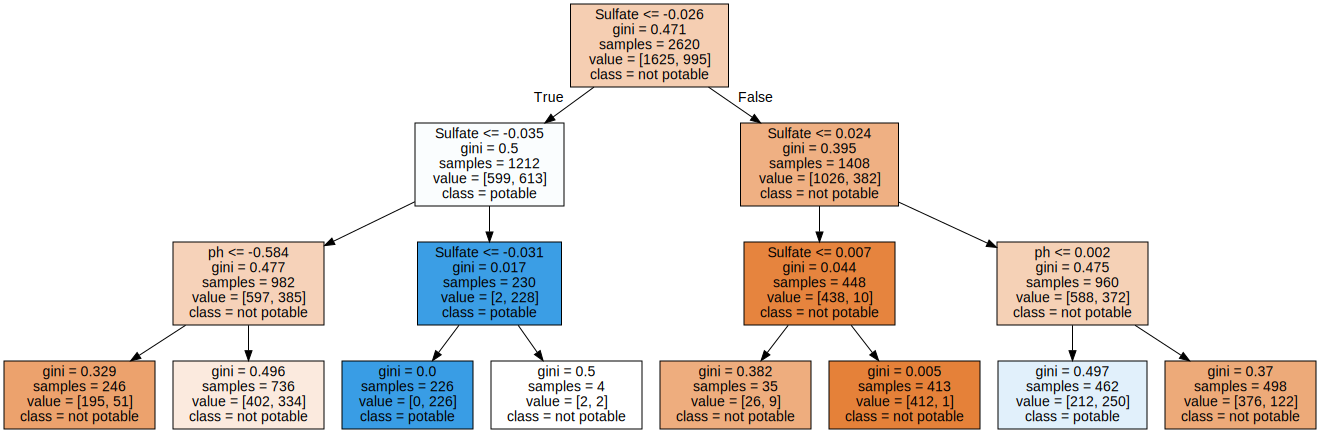

In [11]:
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=1)
clf.fit(Xgravg,Ygravg)

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=list(df.columns[:-1]), 
                                class_names=['not potable', 'potable'],
                                filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph

As we see, the most commonly used feature for the group average dataset is Sulfate, which is used in five of the seven nodes, whereas pH takes up the remaining two.

Now, we display the same tree, but for the None dataset. Since group average adds the most information and none adds the least, this allows for the easiest comparison.

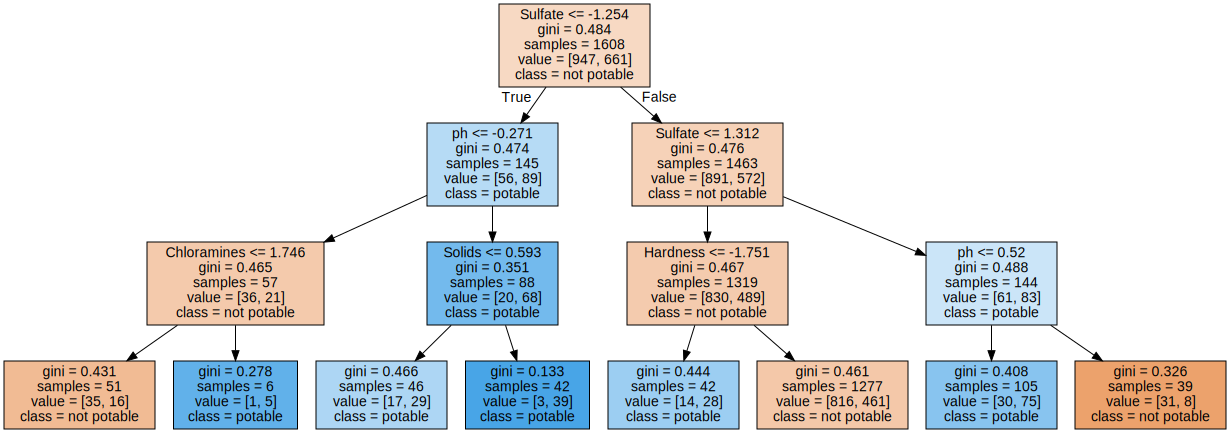

In [12]:
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=1)
clf.fit(Xnone,Ynone)

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=list(df.columns[:-1]), 
                                class_names=['not potable', 'potable'],
                                filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph

In this tree, we see a much more balanced selection of classes, where of the seven nodes, Sulfate and pH are selected for two nodes each, giving five unique features. 

We confirm our hypothesis about group averaging adding information with the following loop:

In [13]:
for col in df.columns:
    print(col,":",len(df[col].dropna()))

ph : 2785
Hardness : 3276
Solids : 3276
Chloramines : 3276
Sulfate : 2495
Conductivity : 3276
Organic_carbon : 3276
Trihalomethanes : 3114
Turbidity : 3276
Potability : 3276


because we see that the two columns with the most missing values are Sulfate and pH. So, when we encode the classification into the dataset by replacing missing values, it shows up in those two columns. Therefore, if the decision tree can find the mean for each feature in those two columns, it can classify a few hundred examples in one or two splits.

This is why groupwise averages are dangerous - they add information that reduces generalization to new datasets while artifically creating trends we shouldn't rely on. We took these averages groupwise since we knew the classification of them. If we wanted to apply this model to data outside of our dataset, we would need to find a way to transform the new data. But what if our new data is unlabeled? Which class' average should we apply? We now have the same problem as before, but now we can't split by group. It seems like we should have just ignored classification for our replacement from the start.

So, what's the takehome message?
For a neural network, using columnwise averages is safe, efficient, and has great performance. 

For a decision tree, if you have all data you'll ever see and want to maximize performance, use groupwise averages. For a realistic scenario, don't use columnwise averages, and consider what fits your situation best.